<h2>Building Regression Trees</h2>


<!--announcements-->
<blockquote>
    <center>
    <img src="forest.jpg" width="400px" />
    </center>
      <p><cite><center>Boosting took a long time to be truly understood.<br>
      ... cynics say we didn't see the forest for all the trees ...<br>
      </center></cite></p>
</blockquote>

<!--announcements-->






<h3>Introduction</h3>
<p>In this assignment you will implement a decision tree algorithm. We've provided a tree structure for you with distinct leaves and nodes. Leaves have two fields, parent (another node) and prediction (a numerical value). Nodes have six fields: 

<ol>
<li> <b>left</b>: node describing left subtree </li>
<li> <b>right</b>: node describing right subtree </li>
<li> <b>parent</b>: the parent of the current subtree. The head of the tree always has <code><b>None</b></code> as its parent. Feel free to initialize nodes with this field set to <code><b>None</b></code> so long as you set the correct parent later on. </li>
<li> <b>cutoff_id</b>: index of feature to cut </li>
<li> <b>cutoff_val</b>: cutoff value c (<=c : left, and >c : right)</li>
<li> <b>prediction</b>: prediction at this node </li>
</ol>
</p>


        

In [1]:
class TreeNode(object):
    """Tree class.
    
    (You don't need to add any methods or fields here but feel
    free to if you like. Our tests will only reference the fields
    defined in the constructor below, so be sure to set these
    correctly.)
    """
    
    def __init__(self, left, right, parent, cutoff_id, cutoff_val, prediction):
        self.left = left
        self.right = right
        self.parent = parent
        self.cutoff_id = cutoff_id
        self.cutoff_val = cutoff_val
        self.prediction = prediction

<h3>Implementing CART</h3>
Before we get started let us add a few packages that you might need. We will also load a data set <a href="https://archive.ics.uci.edu/ml/datasets/Ionosphere">ION</a>, which we will use as our binary test classification problem.

In [2]:
import numpy as np
from pylab import *
from numpy.matlib import repmat
import sys
import matplotlib 
import matplotlib.pyplot as plt
from scipy.io import loadmat
import time
%matplotlib notebook

# load in some binary test data (labels are -1, +1)
data = loadmat("ion.mat")

# Load the training data
xTrIon  = data['xTr'].T
yTrIon  = data['yTr'].flatten()

# Load the test data
xTeIon  = data['xTe'].T
yTeIon  = data['yTe'].flatten()

In [3]:
def spiraldata(N=300):
    r = np.linspace(1,2*np.pi,N)
    xTr1 = np.array([np.sin(2.*r)*r, np.cos(2*r)*r]).T
    xTr2 = np.array([np.sin(2.*r+np.pi)*r, np.cos(2*r+np.pi)*r]).T
    xTr = np.concatenate([xTr1, xTr2], axis=0)
    yTr = np.concatenate([np.ones(N), -1 * np.ones(N)])
    xTr = xTr + np.random.randn(xTr.shape[0], xTr.shape[1])*0.2
    
    xTe = xTr[::2,:]
    yTe = yTr[::2]
    xTr = xTr[1::2,:]
    yTr = yTr[1::2]
    
    return xTr,yTr,xTe,yTe

xTrSpiral,yTrSpiral,xTeSpiral,yTeSpiral=spiraldata(150)

<h3> Implementing regression trees </h3>
<p>First, implement the function <code>sqsplit</code> which takes as input a (weighted) data set with labels and computes the best feature and cut-value of an optimal split based on minimum squared error. The third input is a weight vector which assigns a positive weight to each training sample. The loss you should minimize is the averaged weighted squared-loss:
$$
	{\cal L}(S)=\sum_{i \in L} {w_{i}(y_{i} - T_{L})}^2+\sum_{i \in R} {w_{i}(y_{i} - T_{R})}^2.\label{q2:loss}
$$
<br>
</p>
You are trying building a regression tree, and right now you need to choose a split for the given dataset $S=\{(\vec x_1,y_1),\dots,(\vec x_n,y_n)\}$ (where we have continuous labels $y_i\in{\cal R}$). Suppose you split on some feature $j$ with value $c$ and partition the dataset in to two sets of indices, $L$--the set of indices on the left (i.e., $i \in L \Rightarrow [x_{i}]_{j} < c$)--and $R$--the set of indices on the right (i.e., $i \in R \Rightarrow [x_{i}]_{j} > c$). Suppose you assign every data point on the left the prediction $T_{L}$ and every data point on the right the prediction $T_{R}$. Finally, suppose that each data point $x_{i}$ has an associated weight $w_{i}$, and that the weights are normalized (i.e., $\sum_{i} w_{i} = 1$). 


<p> Now, we show that setting $T_{L}$ and $T_{R}$ to the weighted average label over their respective sets (i.e., $T_{L} = \frac{1}{W_{L}}\sum_{i\in L}w_{i}y_{i}$ and $T_{R} = \frac{1}{W_{R}}\sum_{i\in R}w_{i}y_{i}$) minimizes the loss $\cal L$, where $W_{L}=\sum_{i \in L}w_{i}$ and $W_{R}=\sum_{i \in R} w_{i}$ are the total weight of the left and right side respectively.

<p> We take the derivative of the loss with respect to $T_{L}$ to obtain $$\frac{d}{dT_{L}} {\cal L}(S) = -2\sum_{i \in L}w_{i}(y_i - T_L)=-2\sum_{i\in L}w_iy_i + 2T_{L}\sum_{i}w_{i}$$ Setting this equal to zero and solving, we get $$2T_{L}w_{L}=2\sum_{i \in L}w_{i}y_{i}$$ and therefore $$T_{L} = \frac{1}{W_{L}}\sum_{i \in L}w_{i}y_{i}$$ A symmetric argument holds for $T_{R}$.</p>

So if we know the split, setting $T_{L}$ and $T_{R}$ to the weighted average label over their respective sets minimizes the loss. To find the best split, we can evaluate all possible splits and then search for the split that yields the minimum loss which you will in <code>sqsplit</code>.

In [4]:
def sqsplit(xTr,yTr,weights=None):
    """Finds the best feature, cut value, and loss value.
    
    Input:
        xTr:     n x d matrix of data points
        yTr:     n-dimensional vector of labels
        weights: n-dimensional weight vector for data points
    
    Output:
        feature:  index of the best cut's feature
        cut:      cut-value of the best cut
        bestloss: loss of the best cut
    """
    N,D = xTr.shape
    assert D > 0 # must have at least one dimension
    assert N > 1 # must have at least two samples
    if weights is None: # if no weights are passed on, assign uniform weights
        weights = np.ones(N)
    weights = weights/sum(weights) # Weights need to sum to one (we just normalize them)
    bestloss = np.inf
    feature = np.inf
    cut = np.inf
    
    ### BEGIN SOLUTION
    for d in range(D):
        ii = xTr[:, d].argsort() # sort data along that dimensions
        xs = xTr[ii, d] # sorted feature values
        ws = weights[ii] # sorted weights
        ys = yTr[ii] # sorted labels
        
        # Get indices where we should split
        idif = np.where(np.logical_not(np.isclose(np.diff(xs, axis=0), 0)))[0]
        
        for j in idif:
            T_L = (ws[:j + 1] @ ys[:j + 1]) / np.sum(ws[:j + 1])
            T_R = (ws[j + 1: ] @ ys[j + 1:]) / np.sum(ws[j + 1:])
            
            left_loss = ((ys[:j + 1] - T_L)**2) @ ws[:j + 1]
            right_loss = ((ys[j + 1:] - T_R)**2) @ ws[j + 1:]
            
            loss = left_loss + right_loss            
            if loss < bestloss:
                feature = d
                cut = (xs[j]+xs[j+1])/2
                bestloss = loss
        
    assert feature != np.inf and cut != np.inf
    ### END SOLUTION
    
    return feature, cut, bestloss

In [1]:
t0 = time.time()
fid,cut,loss = sqsplit(xTrIon,yTrIon)
t1 = time.time()

# change 
print('elapsed time: {:0.2f} seconds'.format(t1-t0))
print("It should split on feature 2 on value 0.304")
print("Split on feature %i on value: %2.3f" % (fid,cut))

NameError: name 'time' is not defined

<b>Cart tree:</b><p>Implement the function <code>cart</code> which returns a regression tree based on the minimum squared loss splitting rule. The function takes training data, a maximum depth, and the weight of each training example. Maximum depth and weight are optional arguments. If they are not provided you should make maximum depth infinity and equally weight each example. You should use the function <code>sqsplit</code> to make your splits.</p>

<p>Use the provided <code>TreeNode</code> class to represent your tree. Note that the nature of CART trees implies that every node has exactly 0 or 2 children.</p>


In [8]:
def cart(xTr,yTr,depth=np.inf,weights=None):
    """Builds a CART tree.
    
    The maximum tree depth is defined by "maxdepth" (maxdepth=2 means one split).
    Each example can be weighted with "weights".

    Args:
        xTr:      n x d matrix of data
        yTr:      n-dimensional vector
        maxdepth: maximum tree depth
        weights:  n-dimensional weight vector for data points

    Returns:
        tree: root of decision tree
    """
    n,d = xTr.shape
    if weights is None:
        w = np.ones(n) / float(n)
    else:
        w = weights
    
    ### BEGIN SOLUTION
    index = np.arange(n)
    prediction = yTr.dot(w) / float(np.sum(w))
    if depth == 0 or np.all(yTr == yTr[0]) or np.max(np.abs(np.diff(xTr, axis=0))) < (np.finfo(float).eps * 100):
        # Create leaf Node
        return TreeNode(None, None, None, None, None, prediction)
    else:
        feature,cut,h = sqsplit(xTr,yTr,w)
        left_idx  = index[xTr[:,feature] <= cut]
        right_idx = index[xTr[:,feature] > cut]
        
        left_w  = w[left_idx]
        right_w = w[right_idx]
        left  = cart(xTr[left_idx,:],   yTr[left_idx],  depth=depth-1, weights=left_w)
        right = cart(xTr[right_idx,:],  yTr[right_idx], depth=depth-1, weights=right_w)
        currNode = TreeNode(left, right, None, feature, cut, prediction)
        left.parent  = currNode
        right.parent = currNode
        
        return currNode
    ### END SOLUTION

<p>Implement the function <code>evaltree</code>, which evaluates a decision tree on a given test data set.</p>

In [9]:
def evaltree(root,xTe):
    """Evaluates xTe using decision tree root.
    
    Input:
        root: TreeNode decision tree
        xTe:  n x d matrix of data points
    
    Output:
        pred: n-dimensional vector of predictions
    """
    ### BEGIN SOLUTION
    def evaltreehelper(root,xTe, idx=[]):
        """Evaluates xTe using decision tree root.

        Input:
            root: TreeNode decision tree
            xTe:  n x d matrix of data points

        Output:
            pred: n-dimensional vector of predictions
        """
        assert root is not None
        n = xTe.shape[0]
        pred = np.zeros(n)

        # TODO:
        if len(idx)==0: idx=np.ones(n)==1 

        if root.left is None and root.right is None:
             return np.ones(sum(idx))*root.prediction
            
        assert root.left is not None and root.right is not None
        feature, cutoff = root.cutoff_id, root.cutoff_val

        idxL=idx & (xTe[:,feature] <= cutoff)
        if root.left.left is None and root.left.right is None:
             pred[idxL]=root.left.prediction
        else:
             pred[idxL]=evaltreehelper(root.left, xTe,idxL) 

        idxR=idx & (xTe[:,feature]  > cutoff)
        if root.right.left is None and root.right.right is None:
             pred[idxR]=root.right.prediction
        else:
             pred[idxR]=evaltreehelper(root.right,xTe,idxR)
        return(pred[idx])
    
    return evaltreehelper(root,xTe)
    ### END SOLUTION

In [10]:
t0 = time.time()
root = cart(xTrIon, yTrIon)
t1 = time.time()

tr_err   = np.mean((evaltree(root,xTrIon) - yTrIon)**2)
te_err   = np.mean((evaltree(root,xTeIon) - yTeIon)**2)

print("elapsed time: %.2f seconds" % (t1-t0))
print("Training RMSE : %.2f" % tr_err)
print("Testing  RMSE : %.2f" % te_err)

elapsed time: 0.79 seconds
Training RMSE : 0.00
Testing  RMSE : 0.69


<p>The following code defines a function <code>visclassifier()</code>, which plots the decision boundary of a classifier in 2 dimensions. Execute the following code to see what the decision boundary of your tree looks like on the ion data set. </p>

/home/cheng/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.


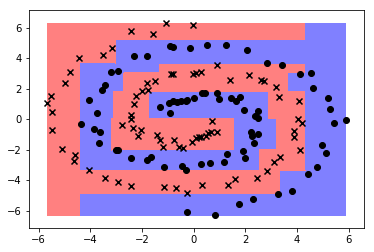

Training error: 0.0000
Testing error:  0.0400


In [11]:
def visclassifier(fun,xTr,yTr,w=[],b=0):
    """
    visualize decision boundary
    Define the symbols and colors we'll use in the plots later
    """

    yTr = np.array(yTr).flatten()
    w = np.array(w).flatten()

    symbols = ["ko","kx"]
    marker_symbols = ['o', 'x']
    mycolors = [[0.5, 0.5, 1], [1, 0.5, 0.5]]
    # get the unique values from labels array
    classvals = np.unique(yTr)

    plt.figure()

    # return 300 evenly spaced numbers over this interval
    res=300
    xrange = np.linspace(min(xTr[:, 0]), max(xTr[:, 0]),res)
    yrange = np.linspace(min(xTr[:, 1]), max(xTr[:, 1]),res)
    
    # repeat this matrix 300 times for both axes
    pixelX = repmat(xrange, res, 1)
    pixelY = repmat(yrange, res, 1).T

    
    xTe = np.array([pixelX.flatten(), pixelY.flatten()]).T

    # test all of these points on the grid
    testpreds = fun(xTe)
    
    # reshape it back together to make our grid
    Z = testpreds.reshape(res, res)
    # Z[0,0] = 1 # optional: scale the colors correctly
    
    # fill in the contours for these predictions
    plt.contourf(pixelX, pixelY, np.sign(Z), colors=mycolors)

    # creates x's and o's for training set
    for idx, c in enumerate(classvals):
        plt.scatter(xTr[yTr == c,0],
            xTr[yTr == c,1],
            marker=marker_symbols[idx],
            color='k'
            )
    
    if w != []:
        alpha = -1 * b / (w ** 2).sum()
        plt.quiver(w[0] * alpha, w[1] * alpha,
            w[0], w[1], linewidth=2, color=[0,1,0])

    plt.axis('tight')
    # shows figure and blocks
    plt.show()

tree=cart(xTrSpiral,yTrSpiral) # compute tree on training data 
visclassifier(lambda X:evaltree(tree,X),xTrSpiral,yTrSpiral)
print("Training error: %.4f" % np.mean(np.sign(evaltree(tree,xTrSpiral)) != yTrSpiral))
print("Testing error:  %.4f" % np.mean(np.sign(evaltree(tree,xTeSpiral)) != yTeSpiral))

<IPython.core.display.Javascript object>


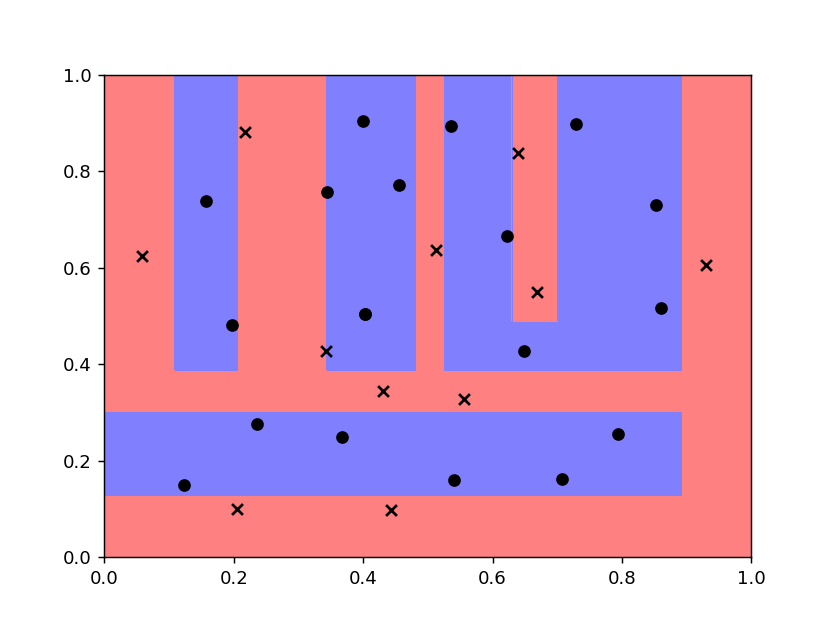

Text(0.5, 1.0, 'Use shift-click to add negative points.')

In [12]:
def onclick_cart(event):
    """
    Visualize cart, including new point
    """
    global xTraining,labels
    # create position vector for new point
    pos=np.array([[event.xdata,event.ydata]]) 
    if event.key == 'shift': # add positive point
        color='or'
        label=1
    else: # add negative point
        color='ob'
        label=-1    
    xTraining = np.concatenate((xTraining,pos), axis = 0)
    labels.append(label);
    marker_symbols = ['o', 'x']
    classvals = np.unique(labels)
        
    mycolors = [[0.5, 0.5, 1], [1, 0.5, 0.5]]
    
    # return 300 evenly spaced numbers over this interval
    res=300
    xrange = np.linspace(0, 1,res)
    yrange = np.linspace(0, 1,res)

    
    # repeat this matrix 300 times for both axes
    pixelX = repmat(xrange, res, 1)
    pixelY = repmat(yrange, res, 1).T

    xTe = np.array([pixelX.flatten(), pixelY.flatten()]).T

    # get decision tree
    tree=cart(xTraining,np.array(labels).flatten())
    fun = lambda X:evaltree(tree,X)
    # test all of these points on the grid
    testpreds = fun(xTe)
    
    # reshape it back together to make our grid
    Z = testpreds.reshape(res, res)
    # Z[0,0] = 1 # optional: scale the colors correctly
    
    plt.cla()    
    plt.xlim((0,1))
    plt.ylim((0,1))
    # fill in the contours for these predictions
    plt.contourf(pixelX, pixelY, np.sign(Z), colors=mycolors)
    
    for idx, c in enumerate(classvals):
        plt.scatter(xTraining[labels == c,0],
            xTraining[labels == c,1],
            marker=marker_symbols[idx],
            color='k'
            )
    plt.show()
    
        
xTraining= np.array([[5,6]])
labels = [1]
%matplotlib notebook
fig = plt.figure()
plt.xlim(0,1)
plt.ylim(0,1)
cid = fig.canvas.mpl_connect('button_press_event', onclick_cart)
plt.title('Use shift-click to add negative points.')

In [ ]:
# optional linear time update rule 
# generate two gaussians as data that has a lot of features

In [13]:
### BEGIN HIDDEN TESTS
# Instructor Code
def DFSxor(t):
    if t.left is not None and t.right is not None:
        if not np.isclose(t.prediction, 0.5):
            return False
        else:
            return DFSxor(t.left) and DFSxor(t.right)
    else:
        return np.isclose(t.prediction, 0.) or np.isclose(t.prediction, 1.)

def DFSpreds(t):
    if t.left is not None and t.right is not None:
        return np.concatenate((DFSpreds(t.left), DFSpreds(t.right)))
    else:
        return np.array([t.prediction])

def DFSxorUnsplittable(t, depth=0):
    if t.left is not None and t.right is not None:
        if not np.isclose(t.prediction, 0.5):
            return False
        else:
            return DFSxorUnsplittable(t.left, depth=depth + 1) and DFSxorUnsplittable(t.right, depth=depth + 1)
    else:
        return np.isclose(t.prediction, 0.5) and depth < 3


xor2 = np.array([[1, 1, 0, 0],
                 [1, 0, 1, 0]]).T
yor2 = np.array( [1, 0, 0, 1])

xor3 = np.array([[1, 1, 1, 1, 0, 0, 0, 0],
                 [1, 1, 0, 0, 1, 1, 0, 0],
                 [1, 0, 1, 0, 1, 0, 1, 0]]).T
yor3 = np.array( [1, 0, 0, 1, 0, 1, 1, 0])

xor4 = np.array([[1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0],
                 [1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0],
                 [1, 1, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0],
                 [1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0]]).T
yor4 = np.array( [1, 0, 0, 1, 0, 1, 1, 0, 0, 1, 1, 0, 1, 0, 0, 1])

xor5 = np.array([[0],[1],[1]])
yor5 = np.array([1,1,-1])

def sqsplit_grader(xTr,yTr,weights=[]):
    """Finds the best feature, cut value, and loss value.
    
    Input:
        xTr:     n x d matrix of data points
        yTr:     n-dimensional vector of labels
        weights: n-dimensional weight vector for data points
    
    Output:
        feature:  index of the best cut's feature
        cut:      cut-value of the best cut
        bestloss: loss of the best cut
    """
    N,D = xTr.shape
    assert D > 0 # must have at least one dimension
    assert N > 1 # must have at least two samples
    if weights == []: # if no weights are passed on, assign uniform weights
        weights = np.ones(N)
    weights = weights/sum(weights) # Weights need to sum to one (we just normalize them)
    bestloss = np.inf
    feature = np.inf
    cut = np.inf
    
    for d in range(D):
        ii = xTr[:,d].argsort() # sort data along that dimensions
        xs = xTr[ii,d] # sorted feature values
        ws = weights[ii] # sorted weights
        ys = yTr[ii] # sorted labels
        
        # Initialize constants
        sL=0.0 # mean squared label on left side
        muL=0.0 # mean label on left side
        wL=0.0 # total weight on left side
        sR=ws.dot(ys**2) #mean squared label on right 
        muR=ws.dot(ys) # mean label on right
        wR=sum(ws) # weight on right
        
        idif = np.where(np.abs(np.diff(xs, axis=0)) > np.finfo(float).eps * 100)[0]
        pj = 0
        
        for j in idif:
            deltas = np.dot(ys[pj:j+1]**2, ws[pj:j+1])
            deltamu = np.dot(ws[pj:j+1], ys[pj:j+1])
            deltaw = np.sum(ws[pj:j+1])
            
            sL += deltas
            muL += deltamu
            wL += deltaw

            sR -= deltas
            muR -= deltamu
            wR -= deltaw
            
            L = sL - muL**2 / wL
            R = sR - muR**2 / wR
            loss = L + R
            
            if loss < bestloss:
                feature = d
                cut = (xs[j]+xs[j+1])/2
                bestloss = loss
            
            pj = j + 1
        
    assert feature != np.inf and cut != np.inf
    
    return feature, cut, bestloss
### END HIDDEN TESTS

In [14]:
### BEGIN HIDDEN TESTS
#test case 1
def sqsplit_test1():
    a = np.isclose(sqsplit(xor4,yor4)[2], .25)
    b = np.isclose(sqsplit(xor3,yor3)[2], .25)
    c = np.isclose(sqsplit(xor2,yor2)[2], .25)
    return a and b and c

#test case 2
def sqsplit_test2():
    x = np.array(range(1000)).reshape(-1,1)
    y = np.hstack([np.ones(500),-1*np.ones(500)]).T
    w = np.ones(1000)
    _, cut, _ = sqsplit(x, y, weights=w)
    # 499.5 is the correct answer but will accept other two answers
    return cut == 499 or cut == 500 or cut == 499.5

# additional test 1
def sqsplit_test3():
    fid,cut,loss = sqsplit(xor5,yor5)
    # cut should be 0.5 but 0 is also accepted
    return fid == 0 and (cut == 0 or cut == 0.5) and np.isclose(loss, 2/3)

assert sqsplit_test1(), "[FAIL] sqsplit Test 1 - calculated bestloss is inconsistent across similar datasets."
assert sqsplit_test2(), "[FAIL] sqsplit Test 2 - calculated best cut location is not showing expected behavior for large datasets."
assert sqsplit_test3(), "[FAIL] sqsplit Test 3 - did you split in the middle of a feature? e.g. [1,1,1,2,2] should not be splitted to [1,1], [1,2,2]."
### END HIDDEN TESTS

In [15]:
### BEGIN HIDDEN TESTS

#test case 3
def cart_test1():
    t=cart(xor4,yor4)
    return DFSxor(t)

#test case 4
def cart_test2():
    y = np.random.rand(16);
    t = cart(xor4,y);
    yTe = DFSpreds(t)[:];
    # Check that every label appears exactly once in the tree
    y.sort()
    yTe.sort()
    return np.all(np.isclose(y, yTe))

def cart_test3():
    xRep = np.concatenate([xor2, xor2])
    yRep = np.concatenate([yor2, 1-yor2])
    t = cart(xRep, yRep)
    return DFSxorUnsplittable(t)

assert cart_test1(), "[FAIL] cart Test 1 - at least one prediction is incorrect."
assert cart_test2(), "[FAIL] cart Test 2 - tree is failing to split the way it should"
assert cart_test3(), "[FAIL] cart Test 3 - tree is failing to split the way it should."
### END HIDDEN TESTS

In [16]:
### BEGIN HIDDEN TESTS
#test case 5
def evaltree_test1():
    t = cart(xor4,yor4)
    xor4te = xor4 + (np.sign(xor4 - .5) * .1)
    inds = np.arange(16)
    np.random.shuffle(inds)
    # Check that shuffling and expanding the data doesn't affect the predictions
    return np.all(np.isclose(evaltree(t, xor4te[inds,:]), yor4[inds]))

#test case 6
def evaltree_test2():
    a = TreeNode(None, None, None, None, None, 1)
    b = TreeNode(None, None, None, None, None, -1)
    c = TreeNode(None, None, None, None, None, 0)
    d = TreeNode(None, None, None, None, None, -1)
    e = TreeNode(None, None, None, None, None, -1)
    x = TreeNode(a, b, None, 0, 10, 0)
    y = TreeNode(x, c, None, 0, 20, 0)
    z = TreeNode(d, e, None, 0, 40, 0)
    t = TreeNode(y, z, None, 0, 30, 0)
    # Check that the custom tree evaluates correctly
    return np.all(np.isclose(
            evaltree(t, np.array([[45, 35, 25, 15, 5]]).T),
            np.array([-1, -1, 0, -1, 1])))

assert evaltree_test1(), "[FAIL] evaltree Test 1 - tree is sensitive to irrelevant perturbations in the data."
assert evaltree_test2(), "[FAIL] evaltree Test 2 - tree is predicting incorrectly."
### END HIDDEN TESTS